## **5. Outpainting**
> Original Source: https://huggingface.co/docs/diffusers/v0.33.1/en/advanced_inference/outpaint

```
> Image Preparation
> Outpaint
```

- Outpainting extends an image beyond its original boundaries, allowing you to **add, replace, or modify visual elements in an image while preserving the original image**.
  - Like inpainting, you want to fill the white area (in this case, the area outside of the original image) with new visual elements while keeping the original image (represented by a mask of black pixels).
  - There are a couple of ways to outpaint, such as with a ControlNet or with Differential Diffusion.

- Make sure you have the controlnet_aux library installed so you can use the ZoeDepth estimator.

```
!pip install -q controlnet_aux
```

In [4]:
import random

import requests
import torch
from controlnet_aux import ZoeDetector
from PIL import Image, ImageOps

from diffusers import (
    AutoencoderKL,
    ControlNetModel,
    StableDiffusionXLControlNetPipeline,
    StableDiffusionXLInpaintPipeline,
)

----
### **Image Preparation**
- Stable Diffusion XL (SDXL) models work best with 1024x1024 images, but you can resize the image to any size as long as your hardware has enough memory to support it.
  - The transparent background in the image should also be replaced with a white background. Create a function (like the one below) that scales and pastes the image onto a white background

In [5]:
def scale_and_paste(original_image):
    aspect_ratio = original_image.width / original_image.height

    if original_image.width > original_image.height:
        new_width = 1024
        new_height = round(new_width / aspect_ratio)
    else:
        new_height = 1024
        new_width = round(new_height * aspect_ratio)

    resized_original = original_image.resize((new_width, new_height), Image.LANCZOS)
    white_background = Image.new("RGBA", (1024, 1024), "white")
    x = (1024 - new_width) // 2
    y = (1024 - new_height) // 2
    white_background.paste(resized_original, (x, y), resized_original)

    return resized_original, white_background

original_image = Image.open(
    requests.get(
        "https://huggingface.co/datasets/stevhliu/testing-images/resolve/main/no-background-jordan.png",
        stream=True,
    ).raw
).convert("RGBA")
resized_img, white_bg_image = scale_and_paste(original_image)

- To avoid adding unwanted extra details, use the `ZoeDepth` estimator to provide additional guidance during generation and to ensure the shoes remain consistent with the original image.

ZoeD_M12_N.pt:   0%|          | 0.00/1.44G [00:00<?, ?B/s]

C:\Users\USER\anaconda3\envs\diffusers-t2i\lib\site-packages\huggingface_hub\file_download.py:144: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\USER\.cache\huggingface\hub\models--lllyasviel--Annotators. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


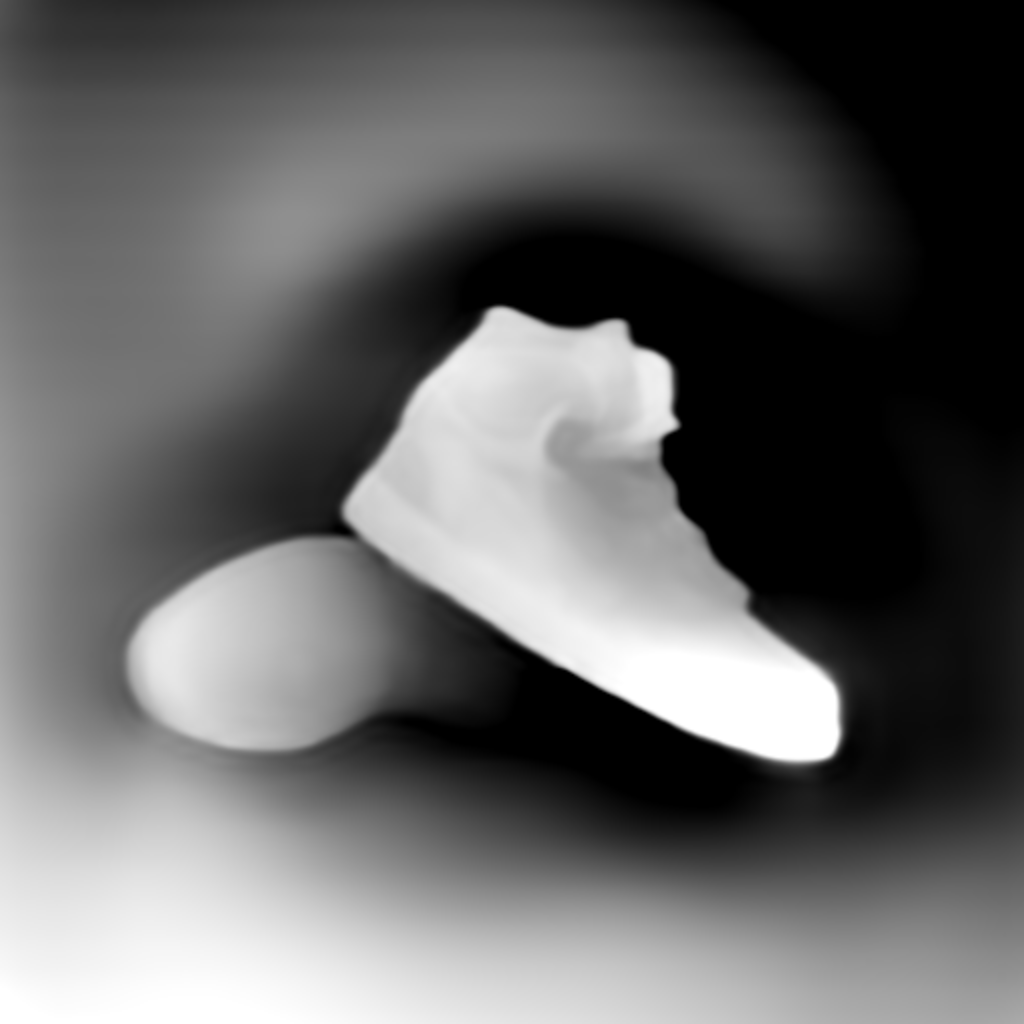

In [6]:
zoe = ZoeDetector.from_pretrained("lllyasviel/Annotators")
image_zoe = zoe(white_bg_image, detect_resolution=512, image_resolution=1024)
image_zoe

----
### **Outpaint**
- Once your image is ready, you can generate content in the white area around the shoes with `controlnet-inpaint-dreamer-sdxl`, a SDXL ControlNet trained for inpainting.
  - Load the inpainting ControlNet, ZoeDepth model, VAE and pass them to the `StableDiffusionXLControlNetPipeline`.
  - Then you can create an optional `generate_image` function (for convenience) to outpaint an initial image.

In [8]:
controlnets = [
    ControlNetModel.from_pretrained(
        "destitech/controlnet-inpaint-dreamer-sdxl", torch_dtype=torch.float16, variant="fp16"
    ),
    ControlNetModel.from_pretrained(
        "diffusers/controlnet-zoe-depth-sdxl-1.0", torch_dtype=torch.float16
    ),
]
vae = AutoencoderKL.from_pretrained("madebyollin/sdxl-vae-fp16-fix", torch_dtype=torch.float16).to("cuda")
pipeline = StableDiffusionXLControlNetPipeline.from_pretrained(
    "SG161222/RealVisXL_V4.0", torch_dtype=torch.float16, variant="fp16", controlnet=controlnets, vae=vae
).to("cuda")

def generate_image(prompt, negative_prompt, inpaint_image, zoe_image, seed: int = None):
    if seed is None:
        seed = random.randint(0, 2**32 - 1)

    generator = torch.Generator(device="cpu").manual_seed(seed)

    image = pipeline(
        prompt,
        negative_prompt=negative_prompt,
        image=[inpaint_image, zoe_image],
        guidance_scale=6.5,
        num_inference_steps=25,
        generator=generator,
        controlnet_conditioning_scale=[0.5, 0.8],
        control_guidance_end=[0.9, 0.6],
    ).images[0]

    return image

prompt = "nike air jordans on a basketball court"
negative_prompt = ""

temp_image = generate_image(prompt, negative_prompt, white_bg_image, image_zoe, 908097)

- Paste the original image over the initial outpainted image.

In [ ]:
x = (1024 - resized_img.width) // 2
y = (1024 - resized_img.height) // 2
temp_image.paste(resized_img, (x, y), resized_img)
temp_image

In [ ]:
# Free Up Memory
pipeline=None
torch.cuda.empty_cache()

- You have an initial outpainted image, load the `StableDiffusionXLInpaintPipeline` with the RealVisXL model to generate the final outpainted image with better quality.
- Prepare a mask for the final outpainted image.
  - To create a more natural transition between the original image and the outpainted background, blur the mask to help it blend better.

In [ ]:
pipeline = StableDiffusionXLInpaintPipeline.from_pretrained(
    "OzzyGT/RealVisXL_V4.0_inpainting",
    torch_dtype=torch.float16,
    variant="fp16",
    vae=vae,
).to("cuda")

mask = Image.new("L", temp_image.size)
mask.paste(resized_img.split()[3], (x, y))
mask = ImageOps.invert(mask)
final_mask = mask.point(lambda p: p > 128 and 255)
mask_blurred = pipeline.mask_processor.blur(final_mask, blur_factor=20)
mask_blurred

- Create a better prompt and pass it to the `generate_outpaint` function to generate the final outpainted image.
  - Paste the original image over the final outpainted background.

In [ ]:
def generate_outpaint(prompt, negative_prompt, image, mask, seed: int = None):
    if seed is None:
        seed = random.randint(0, 2**32 - 1)

    generator = torch.Generator(device="cpu").manual_seed(seed)

    image = pipeline(
        prompt,
        negative_prompt=negative_prompt,
        image=image,
        mask_image=mask,
        guidance_scale=10.0,
        strength=0.8,
        num_inference_steps=30,
        generator=generator,
    ).images[0]

    return image

prompt = "high quality photo of nike air jordans on a basketball court, highly detailed"
negative_prompt = ""

final_image = generate_outpaint(prompt, negative_prompt, temp_image, mask_blurred, 7688778)
x = (1024 - resized_img.width) // 2
y = (1024 - resized_img.height) // 2
final_image.paste(resized_img, (x, y), resized_img)
final_image